In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torch.optim import lr_scheduler
from model import CNN, BasicBlock, ResNet, PretrainedAlexnet, PretrainedAlexnet_binary, PretrainedResnet, PretrainedResnet_binary
from tqdm import tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 1e-4
num_epochs = 20
batch_size = 32
input_size = 224

datapath = 'dataset'

In [3]:
is_binary = False
if is_binary:
    datapath = 'dataset_binary'

In [4]:
class CustomDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx][0]
        if self.transform:
            img = self.transform(img)

        return img, self.imgs[idx][1]


In [5]:
trans = transforms.Resize((input_size, input_size))
train_set = torchvision.datasets.ImageFolder(datapath+'/train', transform=trans)
classes = train_set.classes


In [6]:
train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = torch.utils.data.random_split(train_set, [train_size, valid_size])


In [7]:
train_set = CustomDataset(train_set, transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((input_size, input_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
]))
valid_set = CustomDataset(valid_set, transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
]))


In [8]:
train_len = len(train_set)
class_weights = [0] * len(classes)
sample_weights = [0] * train_len

for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    class_weights[label]+=1
for i in tqdm(range(len(classes))):
    class_weights[i] = (train_len-class_weights[i])/train_len
for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    sample_weights[idx] = class_weights[label]
    
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_set)


100%|██████████| 1676/1676 [00:13<00:00, 123.10it/s]


In [9]:
# model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
# model = PretrainedAlexnet.to(device)
model = PretrainedResnet.to(device)
if is_binary:
    model = PretrainedResnet_binary.to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
total_batch = len(train_loader)

In [11]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [12]:
best_valid_acc = 0

def eval_one_epoch(data_loader):
    global best_valid_acc
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        if accuracy > best_valid_acc:
            if not is_binary:
                torch.save(model, 'best_model.pt')
            else:
                torch.save(model, 'best_model_binary.pt')
        return loss, accuracy, correct_pred, total_pred

In [13]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
valid_class_acc_hist = {classname: [] for classname in classes}

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_loss, train_acc = train_one_epoch(train_loader)
    exp_lr_scheduler.step() # learning rate를 step마다 조절해준다.
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        valid_class_acc_hist[classname].append(accuracy)
        
    pbar.set_description(f"epoch {epoch+1} ==> train acc: {train_acc}, valid acc: {valid_acc}")


epoch 20 ==> train acc: 98.92601776123047, valid acc: 91.66667175292969: 100%|██████████| 20/20 [06:09<00:00, 18.46s/it]


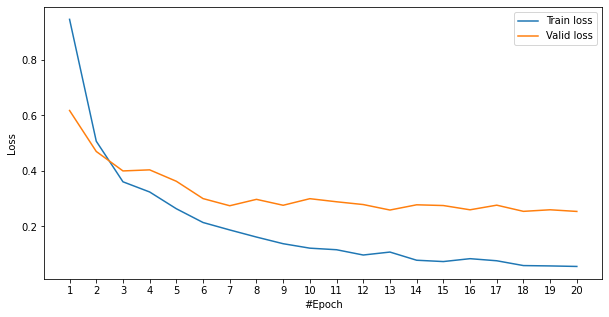

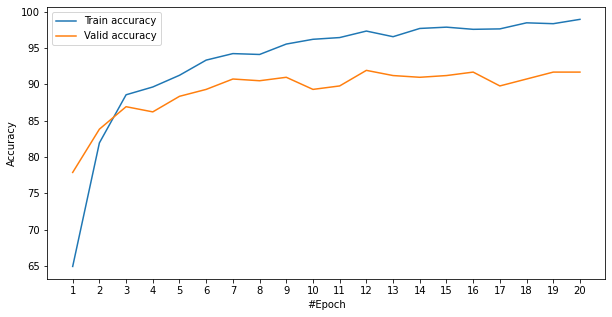

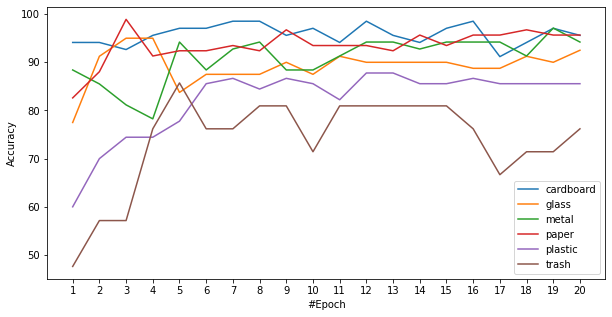

In [14]:
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s' % classname)
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()
